### An introduction to `hycore`

The following notebook provides a simple demonstration of how `hycore` can be use to manage hyperspectral core scanning libraries and facilitate out-of-core processing and the construction of multi-box mosaics and other visualisations. 

For simplicity we do this using completely fake hyperspectral images; though hopefully this shows how `hycore.Shed` instances could be constructed with real data (so long as it is in a format that can be read by `hylite`).

In [1]:
import hycore
import hylite
from hycore.generator import genTray

### 1. Creating a Shed and adding data

To start, lets create a fake hyperspectal scan for two sensors (e.g., SWIR and LWIR) over the same box.

In [2]:
# fake HSI image (sensor 1)
swir, _, mask = genTray(ncores=4, flip=False, masked=False)

# fake HSI image (sensor 2)
lwir = swir.copy()
lwir.data = 1 - swir.data # change the spectra to something different
lwir.data[~mask,:] *= 0.1 # darken background so it looks prettier

# also store the tray mask (separating each core from surrounding box) as a HyImage instance
mask = hylite.HyImage(mask)


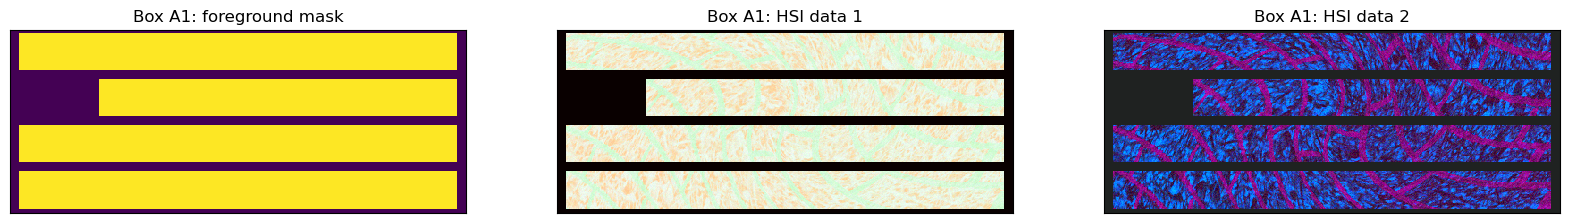

In [3]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(20,6))

mask.quick_plot(0, ax=ax[0])
ax[0].set_title("Box A1: foreground mask")

swir.quick_plot(hylite.SWIR, ax=ax[1], vmin=2, vmax=98)
ax[1].set_title("Box A1: HSI data 1")

lwir.quick_plot(hylite.SWIR, ax=ax[2], vmin=2, vmax=98)
ax[2].set_title("Box A1: HSI data 2")

fig.show()

`hycore` can then be used to easily and, importantly, consistently store these three image datasets for this box. First we need to create a coreshed (`hycore.Shed`) instance to put them in (though or most larger projects this only needs to be done once), and then we can add and save the box scan.

In [4]:
# create a new hycore.Shed data structure in the current directory
import os
S = hycore.Shed(name='MyShed', root=os.getcwd() )

In [5]:
# add our HSI data to a new (or pre-existing) box
box = S.addHSI(sensor='SWIR', hole='A', boxID='1', image=swir)
box = S.addHSI(sensor='LWIR', hole='A', boxID='1', image=lwir)

Creating A
Creating b1


Once we have a `hycore.Box` instance we can also quickly add arbitrary data (e.g., our `mask` image).

In [6]:
box.mask = mask # add a mask to the box
box.start = 10 # set start and end depth on newly created boxes as follows
box.end = 15

And save this to disk (and, if memory is an issue, clear these datasets from RAM).

In [7]:
box.save() # save all variables loaded into this box (so in this case the two HSI images and our mask)
box.free()

Note that `hycore` uses the `hylite.HyCollection` data structure to facilitate seamless loading and saving of data from these directories. If an attribute of a box is requested (e.g., `box.mask`) then it will be either returned directly from RAM (if it has been previously loaded) or, if the file exists on disk but there is no corresponding data in RAM, loaded into memory. 

The print function can be used to show this in action.

In [8]:
box.print() # no attributes in RAM

Attributes stored in RAM:
Attributes stored in header:
	 end = 15
	 start = 10
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - SWIR.dat
	 - mask.dat
	 - sensor_list.npy
	 - LWIR.dat


In [9]:
m = box.mask # load the mask into memory
box.print() # now the mask variable will be in RAM

Attributes stored in RAM:
	 - <class 'hylite.hyimage.HyImage'> called mask
Attributes stored in header:
	 end = 15
	 start = 10
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - SWIR.dat
	 - sensor_list.npy
	 - LWIR.dat


Importantly, this framework facilitates out-of-core processing by seamlessly allowing datasets to be loaded, processed and saved onto disk without writing lots of IO code. That said, if RAM is limited then it is important to remember to free attributes from each box once processing is complete, as follows.

In [10]:
box.free() # delete all attributes stored in RAM ( box.save() should be called first if anything has been changed ).
box.print() # now there is nothing in RAM

Attributes stored in RAM:
Attributes stored in header:
	 end = 15
	 start = 10
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - SWIR.dat
	 - mask.dat
	 - sensor_list.npy
	 - LWIR.dat


In [11]:
import shutil
from pathlib import Path
if os.path.exists( Path(os.getcwd()) / 'MyShed.shed' ):
    shutil.rmtree( Path(os.getcwd()) / 'MyShed.shed' ) # cleanup by deleting the shed we just created

### 2. Navigating through Shed instances

Lets be honest though; a core shed containing a single box (only) is rather boring. Lets now create a new, more complex shed (essentially using the function above, but after creating a more diverse set of synthetic HSI data).

In [12]:
from hycore import get_sandbox

S = get_sandbox( fill=True, vis=False, mosaic=False ) # construct a fake test shed with a few drillholes and a handfull of HSI data

Creating H01
Creating b001
Creating b002
Creating b003
Creating H03
Creating b001
Creating b002
Creating b003
Creating H02
Creating b001
Creating b004


Similarly to the `hycore.Box` class used in the previous section, the `hycore.Shed` instance is also a child class of  `hylite.HyCollection`. Hence, we can use the `print` function to explore it's contents.

In [13]:
S.print() # see what data (e.g., drillholes) are in this Shed

Attributes stored in RAM:
Attributes stored in header:
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - H03.hyc
	 - H02.hyc
	 - H01.hyc


In [14]:
hole3 = S.H02 # load hole number 2
hole3.print() # see what is in this hole

Attributes stored in RAM:
Attributes stored in header:
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - b001.hyc


In [15]:
box1 = S.H02.b001
box1.print()

Attributes stored in RAM:
Attributes stored in header:
	 end = <class 'str'>
	 start = <class 'str'>
	 ctype = <class 'str'>
Attributes stored on disk:
	 - results.hyc
	 - FENIX.dat
	 - sensor_list.npy
	 - mask.png
	 - LWIR.dat


More usefully, we can also get lists of all of the holes and/or boxes in each of these data structures.

In [16]:
# get all of the holes in the core shed
all_holes = S.getHoles()
print([h.name for h in all_holes])

['H01', 'H02', 'H03']


In [17]:
# get all the boxes in the whole core Shed
all_boxes = S.getBoxes()
print([b.getFullName() for b in all_boxes])

['eldorado/H01/b001', 'eldorado/H01/b002', 'eldorado/H01/b003', 'eldorado/H01/b004', 'eldorado/H02/b001', 'eldorado/H03/b001', 'eldorado/H03/b002', 'eldorado/H03/b003']


In [18]:
# get all the boxes in the first returned hole
H01_boxes = all_holes[0].getBoxes()
print([b.getFullName() for b in H01_boxes])

['eldorado/H01/b001', 'eldorado/H01/b002', 'eldorado/H01/b003', 'eldorado/H01/b004']


Holes or boxes can also be retrieved directly using their string names, if needed.

In [19]:
H02 = S.getHole('H02')
b001 = H02.getBox('b001')
b003 = S.getBox(hole='H01', box='b003')

It is also worth noting that the start and end depth of specific boxes can be retrieved as follows

In [20]:
start = b003.start
end = b003.end
print(f"Box 3 goes from {start} until {end} meters")

Box 3 goes from 8 until 12 meters


### 3. Generating preview visualisations

While *hycore* uses ENVI format to store hyperspectral data, it is often useful to create preview .png files to quickly show what a box looks like, or for visualisation through e.g., the `hywiz` web viewer.

We can quickly and easily construct these preview visualisations using the `updateViz` function of each box. This can also be used to create a small thumbnail PNG (also for use in e.g., `hywiz`).

In [21]:
# construct preview PNG images for every box
for b in S.getBoxes():
    b.updateVis(sensors=['FENIX', 'LWIR'], qaqc=False, thumb='FENIX')

Using the `hylite.HyCollection.get` function we can explicitely specify that we want to access the `png` file (rather than the ENVI file with the same name). 

(<Figure size 1800x723.529 with 1 Axes>, <Axes: >)

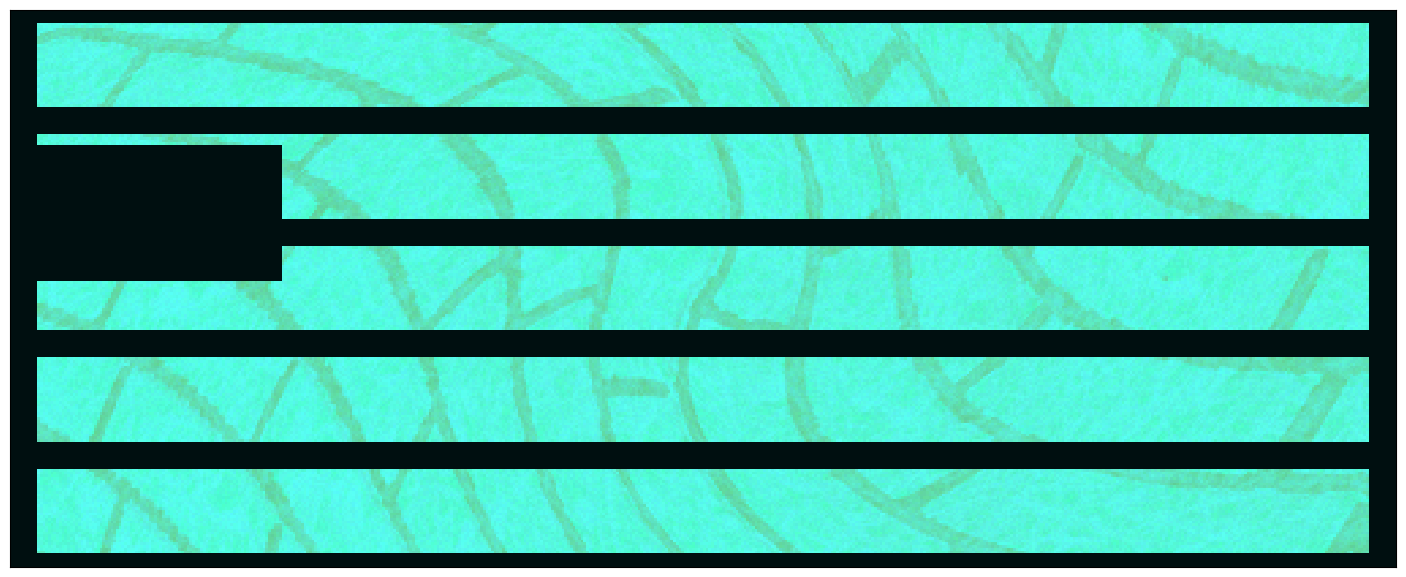

In [22]:
# plot it for the last box
b.get('FENIX.png').quick_plot((0,1,2), vmin=2, vmax=98) # note the g

### 4. Templates and mosaics

Lastly, we can use `hycore` to construct potentially complex `Template` instances, which store mappings between pixels in individual core boxes and larger (e.g. entire drillhore, or even entire project) mosaics. 

First, we will create a template for a simple "fence" mosaic in which core boxes are cropped and layed side-by-side, as though on a core rack.

In [23]:
hole = S.getHole('H03')
T = hole.getTemplate(method='fence', # specify the fence layout
                     res=2e-3) # specify the size of each pixel in meters [ so we know where to place everything ) 

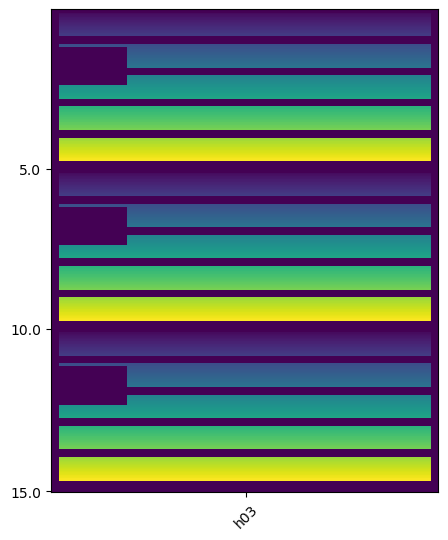

In [24]:
fig,ax = plt.subplots(1,1,figsize=(5,10))
T.quick_plot(2, ax=ax, vmin=1 ) # plot the y-coordinate of each pixel in the template mapping
fig.show()

Using this template, we can easily push data or analysis results (most quickly, though not by necessity, from previously constructed PNG files) to construct image mosaics.

In [25]:
mosaic = T.apply('FENIX.png') # push data from all FENIX.png preview images into our mosaic layout

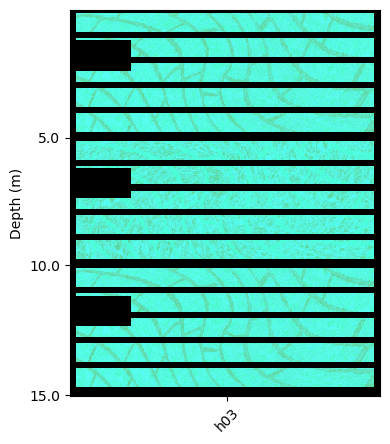

In [26]:
fig,ax = plt.subplots(1,1,figsize=(4,10))
mosaic.quick_plot((0,1,2), vmin=2, vmax=98, rot=False, ax=ax)
ax.set_ylabel('Depth (m)')
T.add_ticks( ax ) # add depth ticks to plot
fig.show()

Lastly, more complex (e.g., multi-drillhole mosaics) can be constructed using a `hycore.templates.Canvas` object. Templates from individual boxes can be added to a `Canvas` instance along with a specific grouping (e.g., by drillhole). Complex combined Templates can then be extracted for specific combinations of groups, layouts and even depth offsets (to e.g., align data relative to a marker horizon).

In [27]:
from hycore.templates import Canvas
C = Canvas()

# put all boxes into the canvas, grouped by their hole name
for b in S.getBoxes():
    C.add( group=b.holeName(), template=b.getTemplate(method='sticks', axis=0 ) )

In [28]:
# get a template showing Hole1 and Hole3 next o

In [29]:
T2 = C.hpole( from_depth = 2.5, to_depth = 10.0, res=2e-3, scaled=True, 
             groups=['H01','H03'], # plot only these two holes
             depth_offsets = dict(H01=-1, H03=1.5) # offset depths by this amount (by subtraction) to change alignment
            )

mosaic = T2.apply('FENIX.png') # push data from all FENIX.png preview images into our mosaic layout

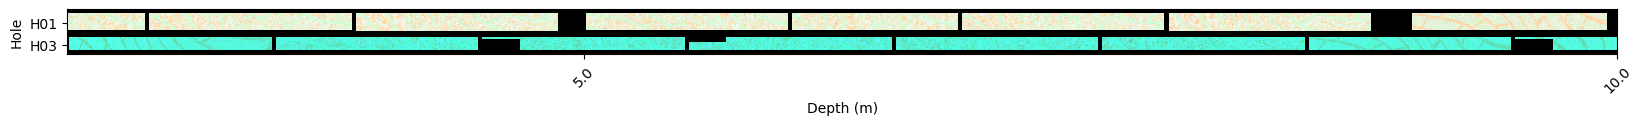

In [30]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
mosaic.quick_plot((0,1,2), vmin=2, vmax=98, rot=False, ax=ax)
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Hole')
T2.add_ticks( ax ) # add depth ticks to plot
fig.show()

In [31]:
# cleanup; it isn't easy being clean
import shutil
from pathlib import Path
if os.path.exists( Path(os.getcwd()) / 'sandbox' ):
    shutil.rmtree( Path(os.getcwd()) / 'sandbox' ) # cleanup by deleting the shed we just created